In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [3]:
ss=1
main_labels = data_utils.load_main_task_labels(ss)
rep_labels = data_utils.load_repeat_task_labels(ss)
concat_labels = pd.concat([main_labels, rep_labels], axis=0)
pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
is_main_grid = concat_labels['is_main_grid']==1

In [ ]:
xlabs = np.array(main_labels['ptx'])[main_labels['is_main_grid']==True]
ylabs = np.array(main_labels['pty'])[main_labels['is_main_grid']==True]
unx, uny = np.unique(xlabs), np.unique(ylabs)
pt_labs = np.array([xlabs, ylabs]).T
grid_pts, grid_labs, counts = np.unique(pt_labs, axis=0, return_inverse=True, return_counts=True)
grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])
grid_pt_strs

In [5]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [47]:
pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
is_main_grid = concat_labels['is_main_grid']==1

grid_pts, grid_labs_main, counts = np.unique(pt_labs[is_main_grid], axis=0, return_inverse=True, return_counts=True)
# grid labs are nan for the off-grid trials
grid_labs_all = np.full(fill_value=np.nan, shape=np.shape(is_main_grid))
grid_labs_all[is_main_grid] = grid_labs_main

In [22]:
center = 2.5

acc_correct_hard = np.zeros((n_subjects, n_rois,2))
acc_incorrect_hard = np.zeros((n_subjects, n_rois,2))

for si, ss in enumerate(subjects):
    
    ss=1
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    concat_labels = pd.concat([main_labels, rep_labels], axis=0)
    pt_labs = np.array([concat_labels['ptx'], concat_labels['pty']]).T
    is_main_grid = concat_labels['is_main_grid']==1
    grid_pts, grid_labs_main, counts = np.unique(pt_labs[is_main_grid], axis=0, return_inverse=True, return_counts=True)

    for ri in range(n_rois):

        # which of 16 categories did classifier predict?
        pred = dec_withintask['pred_labs_all'][ss][ri,:].astype(int)

        # what are actual coordinates of those predictions?
        pred_coords = grid_pts[pred]

        for ti, tt in enumerate([1,2]):

            task_inds = concat_labels['task']==tt
            
            # analyze predictions for the axis of interest
            coord_actual = np.array(pt_labs[:,ti])[task_inds]
            categ_actual = 3-np.array(concat_labels['category_unmapped'])[task_inds].astype(int)
            categ_check = (np.array(pt_labs[:,ti])>center)[task_inds].astype(int) + 1

            assert(np.all(categ_actual==categ_check))

            categ_subjresp = 3-np.array(concat_labels['resp_unmapped'])[task_inds].astype(int)

            categ_classpred = (pred_coords[:,ti]>center)[task_inds].astype(int) + 1

            is_hard = ~is_main_grid[task_inds]

            correct = categ_subjresp==categ_actual
            # print(np.mean(correct))

            acc_correct_hard[si, ri, ti] = np.mean(categ_classpred[correct & is_hard]==categ_actual[correct & is_hard])
            acc_incorrect_hard[si, ri, ti] = np.mean(categ_classpred[~correct & is_hard]==categ_actual[~correct & is_hard])


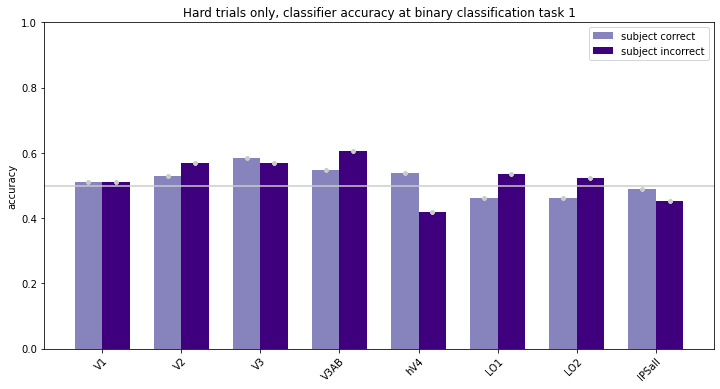

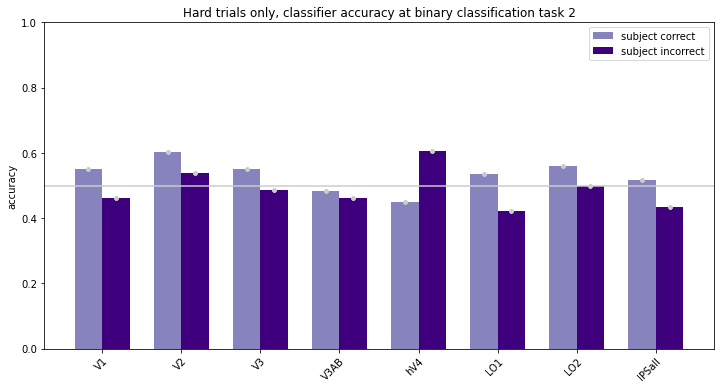

In [21]:
for ti in [0,1]:

    colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

    vals = np.concatenate([acc_correct_hard[:,:,ti:ti+1], acc_incorrect_hard[:,:,ti:ti+1]], axis=2)

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

    plot_utils.plot_multi_bars(mean_data = meanvals, \
                               err_data = semvals, \
                               point_data = vals, \
                               add_ss_lines=False,
                               colors = colors, \
                               space = 0.15, \
                               title = 'Hard trials only, classifier accuracy at binary classification task %d'%(ti+1), \
                               ylim = [0, 1.0], \
                               horizontal_line_pos = 0.5,
                               xticklabels = roi_names, \
                               ylabel = 'accuracy', \
                               legend_overlaid=True, \
                               legend_separate=False, \
                               legend_labels = ['subject correct', 'subject incorrect']);

In [12]:
np.mean(acc_correct_hard, axis=0)

array([[0.50943396, 0.55172414],
       [0.52830189, 0.60344828],
       [0.58490566, 0.55172414],
       [0.54716981, 0.48275862],
       [0.53773585, 0.44827586],
       [0.46226415, 0.53448276],
       [0.46226415, 0.56034483],
       [0.49056604, 0.51724138]])

In [13]:
np.mean(acc_incorrect_hard, axis=0)

array([[0.51162791, 0.46052632],
       [0.56976744, 0.53947368],
       [0.56976744, 0.48684211],
       [0.60465116, 0.46052632],
       [0.41860465, 0.60526316],
       [0.53488372, 0.42105263],
       [0.52325581, 0.5       ],
       [0.45348837, 0.43421053]])

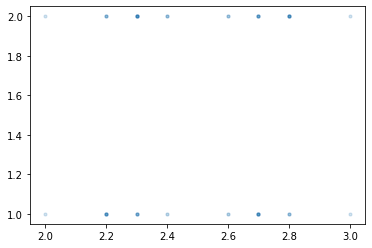

In [123]:
plt.figure()
plt.plot(coord_actual[is_hard], categ_classpred[is_hard],'.', alpha=0.05)

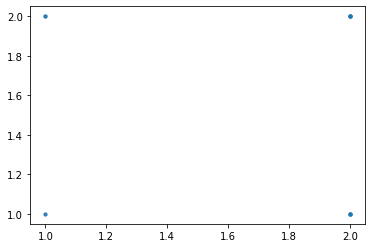

In [126]:
plt.figure()
plt.plot(categ_subjresp[is_hard], categ_classpred[is_hard],'.', alpha=0.05)

In [124]:
np.corrcoef(coord_actual[is_hard], categ_classpred[is_hard])

array([[1.        , 0.05961902],
       [0.05961902, 1.        ]])

In [127]:
np.corrcoef(categ_subjresp[is_hard], categ_classpred[is_hard])

array([[ 1.        , -0.03382765],
       [-0.03382765,  1.        ]])

In [98]:
categ_actual

array([                   1,                    2,                    1,
       ..., -9223372036854775808, -9223372036854775808,
       -9223372036854775808])

In [102]:
np.mean(categ_actual==categ_subjresp)

0.7743055555555556

In [103]:
np.mean(categ_actual==categ_classpred)

0.6041666666666666

In [111]:
np.unique(pt_labs[(~is_main_grid) & task_inds, ti])

array([2. , 2.2, 2.3, 2.4, 2.6, 2.7, 2.8, 3. ])

In [87]:
ti = 1; tt = 2;

task_inds = concat_labels['task']==tt
categ = np.array(concat_labels['category_unmapped']).astype(int)
categ_check = 2-(np.array(pt_labs[:,ti])>center).astype(int)

np.all(categ[task_inds]==categ_check[task_inds])

True

In [80]:
categ_check

array([2, 1, 2, ..., 1, 1, 1])

In [82]:
np.array(concat_labels['category_unmapped'])

array([ 1.,  2.,  1., ..., nan, nan, nan])

In [67]:
concat_labels['correct_resp']

0      1
1      2
2      1
3      2
4      1
      ..
571    1
572    1
573    1
574    2
575    1
Name: correct_resp, Length: 2304, dtype: int64

In [66]:
concat_labels['resp_unmapped']

0      1.0
1      2.0
2      1.0
3      2.0
4      1.0
      ... 
571    NaN
572    NaN
573    NaN
574    NaN
575    NaN
Name: resp_unmapped, Length: 2304, dtype: float64

In [66]:
concat_labels['resp_unmapped']

0      1.0
1      2.0
2      1.0
3      2.0
4      1.0
      ... 
571    NaN
572    NaN
573    NaN
574    NaN
575    NaN
Name: resp_unmapped, Length: 2304, dtype: float64

In [50]:
grid_labs_all

array([12.,  3., nan, ...,  0., nan,  5.])

In [44]:
is_main_grid

0      1
1      1
2      0
3      0
4      1
      ..
571    1
572    1
573    1
574    0
575    1
Name: is_main_grid, Length: 2304, dtype: int64

In [ ]:
grid_labs_actual = con

In [53]:
ri = 0;

pred = dec_withintask['pred_labs_all'][1][ri,:].astype(int)

pred_coords = grid_pts[pred]


In [54]:
pred_coords.shape

(2304, 2)

In [56]:
pt_labs.shape

(2304, 2)

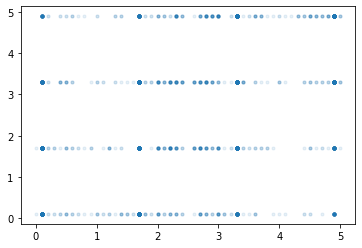

In [58]:
plt.figure()
plt.plot(pt_labs[:,0], pred_coords[:,0], '.',alpha=0.1)

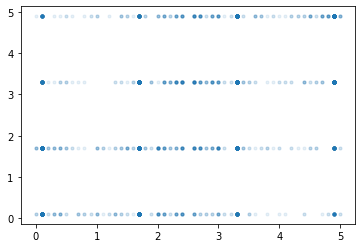

In [61]:
plt.figure()
plt.plot(pt_labs[:,1], pred_coords[:,1], '.',alpha=0.1)

In [59]:
np.corrcoef(pt_labs[:,0], pred_coords[:,0])

array([[1.        , 0.37405063],
       [0.37405063, 1.        ]])

In [60]:
np.corrcoef(pt_labs[:,1], pred_coords[:,1])

array([[1.        , 0.44633584],
       [0.44633584, 1.        ]])

In [6]:
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### Accuracy versus c (regularization)

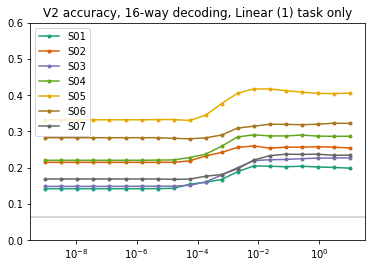

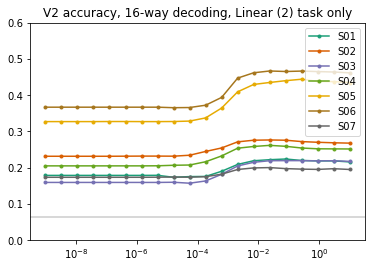

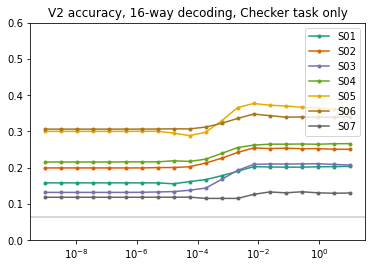

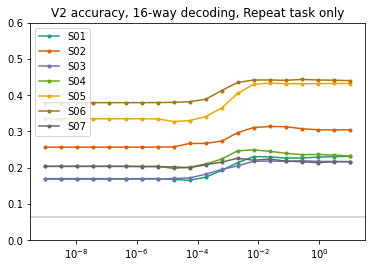

In [7]:
rr = 1;

c_values = np.logspace(-9, 1, 20)
# for rr in range(n_rois):
# for rr in [0,1,2,3]:
for ti in range(4):

    plt.figure()

    for si in range(n_subjects):

        vals = np.nanmean(dec_withintask['acc_each_cval'][si, rr, ti, :, :], axis=0)

        plt.plot(c_values, vals, '.-', color=subcolors[si,:], )

    plt.gca().set_xscale('log')
    plt.legend(['S%02d'%ss for ss in subjects])

    plt.ylim([0, 0.6])
    plt.axhline(1/16, color=[0.8, 0.8, 0.8])
    plt.title('%s accuracy, 16-way decoding, %s task only'%(roi_names[rr], task_names[ti]))

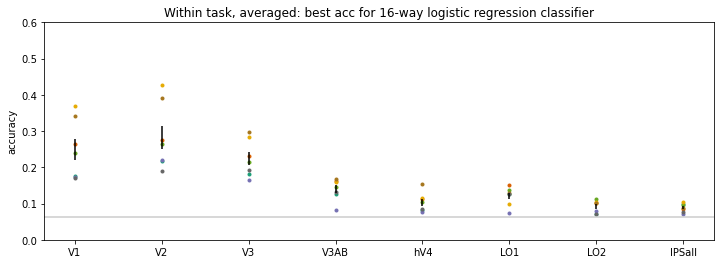

In [8]:
vals = np.mean(dec_withintask['acc_bytask'], axis=2)

n_subj = vals.shape[0]
n_rois = vals.shape[1]
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj)
plt.figure(figsize=(12,4))
plt.errorbar(np.arange(n_rois), meanvals, semvals, linestyle='none',color='k', zorder=10)
for si in range(n_subj):
    plt.plot(np.arange(n_rois), vals[si,:], '.', color=subcolors[si,:])
plt.xticks(np.arange(n_rois), roi_names);
plt.ylim([0, 0.6])
plt.axhline(1/16, color=[0.8, 0.8, 0.8])
plt.ylabel('accuracy')
plt.title('Within task, averaged: best acc for 16-way logistic regression classifier');

#### Accuracy broken down by task

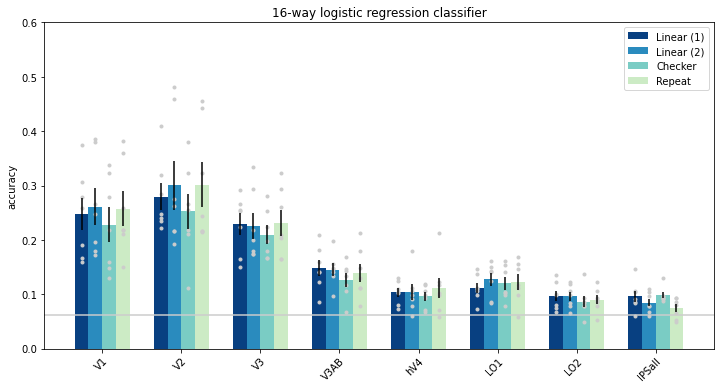

In [9]:
vals = dec_withintask['acc_bytask']

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subj-1)

plot_utils.plot_multi_bars(mean_data = meanvals, \
                           err_data = semvals, \
                           point_data = vals, \
                           add_ss_lines=False,
                           colors = task_colors, \
                           space = 0.15, \
                           title = '16-way logistic regression classifier', \
                           ylim = [0, 0.6], \
                           horizontal_line_pos = 1/16,
                           xticklabels = roi_names, \
                           ylabel = 'accuracy', \
                           legend_overlaid=True, \
                           legend_separate=False, \
                           legend_labels = np.array(task_names));